# На основі даних 2 датасетів про A/B тестування, розрахувати основні маркетингові показники та виявити, яка зміна була ефективнішою та принесла більшу прибутковість:
### CTR = кліки на сайті/покази * 100%
### CPC = витрати / кліки на сайті
### CPM = витрати / покази * 1000
### CPA = витрати / кількість покупок
### CR = кількість покупок / кліки на сайті * 100%

## Результати подати в текстовому та графічних виглядах. Сформулювати грунтовні висновки

#### Імпортуємо необхідні бібліотеки

In [276]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta, datetime
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind

#### Зчитуємо дані та обираємо стовпці які нас цікавлять

In [277]:
data_test_group=pd.read_csv('test_group.csv')
data_control_group=pd.read_csv('control_group.csv')

print(data_control_group)
print(data_test_group)


       Campaign Name   Date  Spend [USD]  # of Impressions   Reach  \
0   Control Campaign  43678         2280             82702   56930   
1   Control Campaign  43679         1757            121040  102513   
2   Control Campaign  43680         2343            131711  110862   
3   Control Campaign  43681         1940             72878   61235   
4   Control Campaign  43683         3083            109076   87998   
5   Control Campaign  43684         2544            142123  127852   
6   Control Campaign  43685         1900             90939   65217   
7   Control Campaign  43686         2813            121332   94896   
8   Control Campaign  43687         2149            117624   91257   
9   Control Campaign  43688         2490            115247   95843   
10  Control Campaign  43689         2319            116639  100189   
11  Control Campaign  43690         2697             82847   68214   
12  Control Campaign  43691         1875            145248  118632   
13  Control Campaign

### Переходимо до розрахунку маркетингових показників. Після , запишемо показники в нові файли


In [278]:
def calculate_parameters(df):
   
    # Рассчитываем CTR и добавляем его в новый столбец
    df['CTR'] = (df['# of Website Clicks'] / df['# of Impressions']) * 100
    df['CPC'] = (df['Spend [USD]'] / df['# of Website Clicks'])
    df['CPM'] = (df['Spend [USD]'] / df['# of View Content']) * 1000
    df['CPA'] = (df['Spend [USD]'] / df['# of Purchase'])
    df['CR'] = (df['# of Purchase'] / df['# of Website Clicks'])*100
    df['ROAS'] = (df['# of Purchase'] / df['# of Website Clicks'])*100
    return df

data_control_group = pd.read_csv('control_group.csv')
data_with_ctr = calculate_parameters(data_control_group)
data_with_ctr.to_csv('control_group_with_indicators.csv', index=False)

data_control_group = pd.read_csv('test_group.csv')
data_with_ctr = calculate_parameters(data_control_group)
data_with_ctr.to_csv('test_group_with_indicators.csv', index=False)
print("Файли збережені")

Файли збережені


## Відкриваємо заново файли з показниками. Конвертуємо дату в зручний формат

In [279]:
data_test_group=pd.read_csv('test_group_with_indicators.csv')
data_control_group=pd.read_csv('control_group_with_indicators.csv').iloc[:,:]

base_date = datetime(1900, 1, 1)
data_test_group['Date'] = data_test_group['Date'].apply(lambda x: (base_date + timedelta(days=x-2)).strftime('%d.%m.%Y'))
data_control_group['Date'] = data_control_group['Date'].apply(lambda x: (base_date + timedelta(days=x-2)).strftime('%d.%m.%Y'))


print(data_test_group)
print(data_test_group)

    Campaign Name        Date  Spend [USD]  # of Impressions   Reach  \
0   Test Campaign  01.08.2019         2740             39550   35820   
1   Test Campaign  02.08.2019         2274            100719   91236   
2   Test Campaign  03.08.2019         2097             70263   45198   
3   Test Campaign  04.08.2019         2442             78451   25937   
4   Test Campaign  06.08.2019         2190             42684   31489   
5   Test Campaign  07.08.2019         2570             53986   42148   
6   Test Campaign  08.08.2019         2648             33669   20149   
7   Test Campaign  09.08.2019         2384             45511   31598   
8   Test Campaign  10.08.2019         2522             95054   79632   
9   Test Campaign  11.08.2019         2152             83633   71286   
10  Test Campaign  12.08.2019         2563            124591   10598   
11  Test Campaign  13.08.2019         1704             65827   49531   
12  Test Campaign  14.08.2019         2269             56304   2

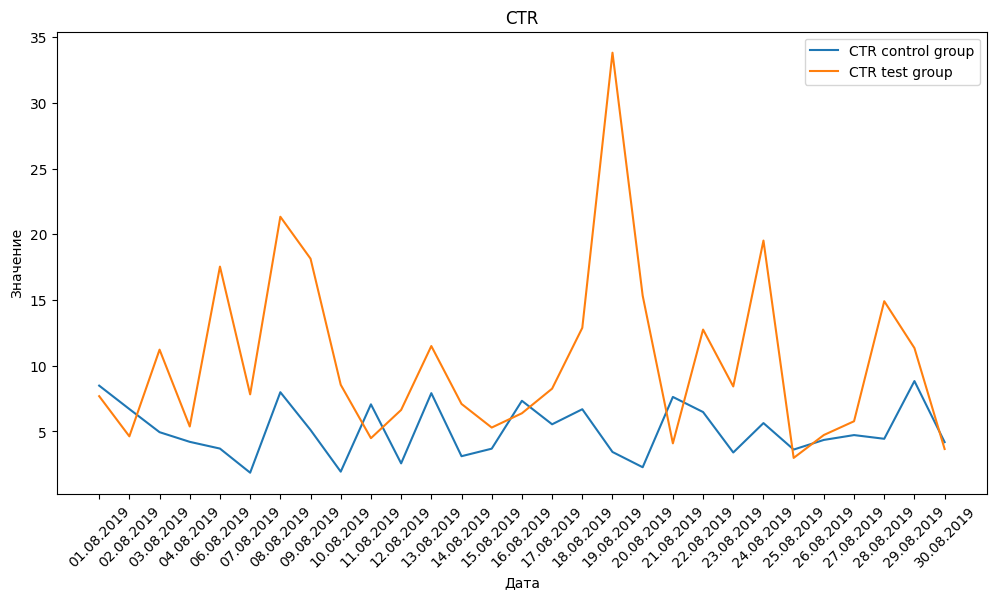

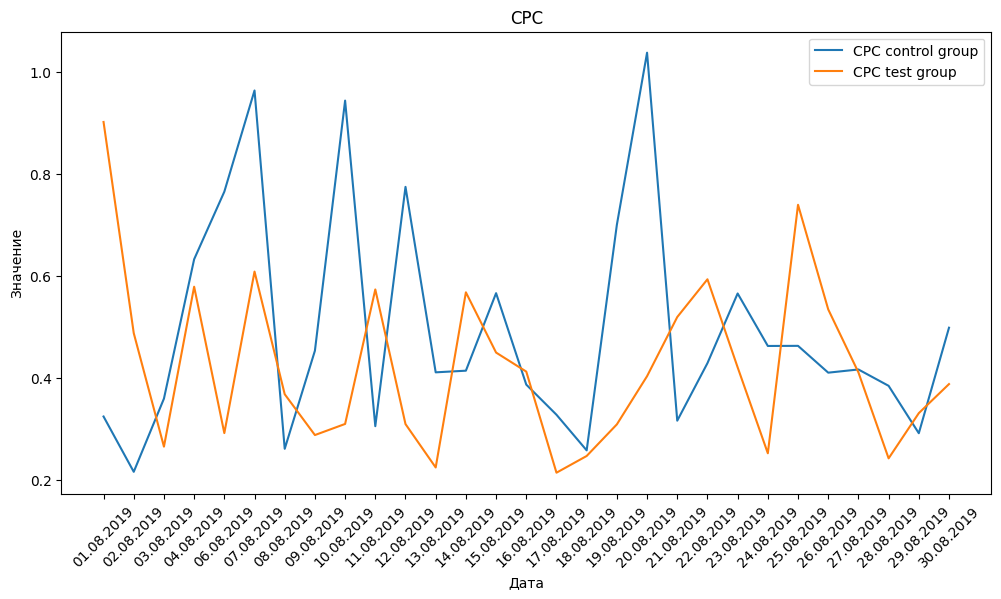

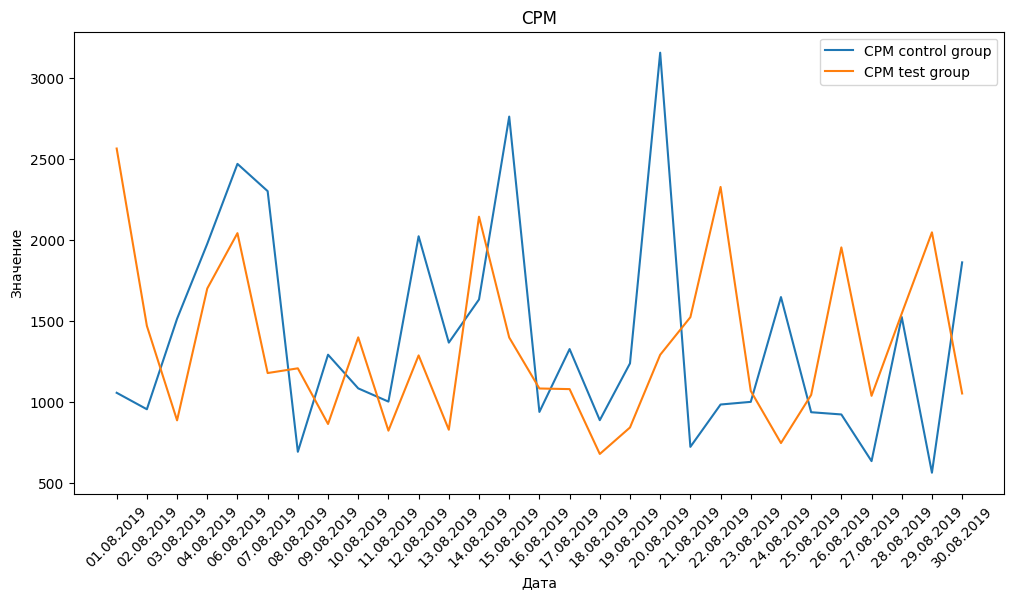

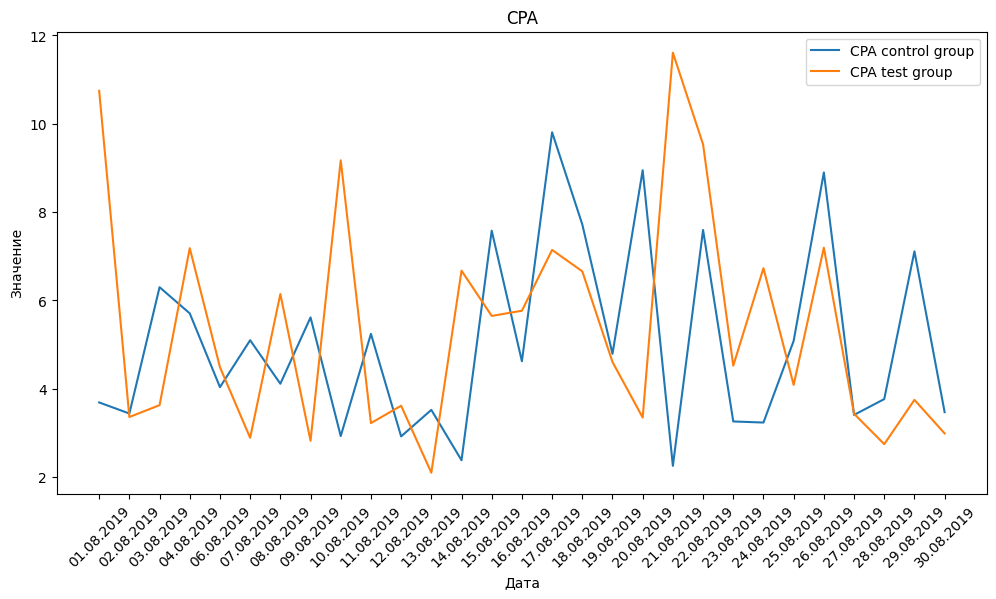

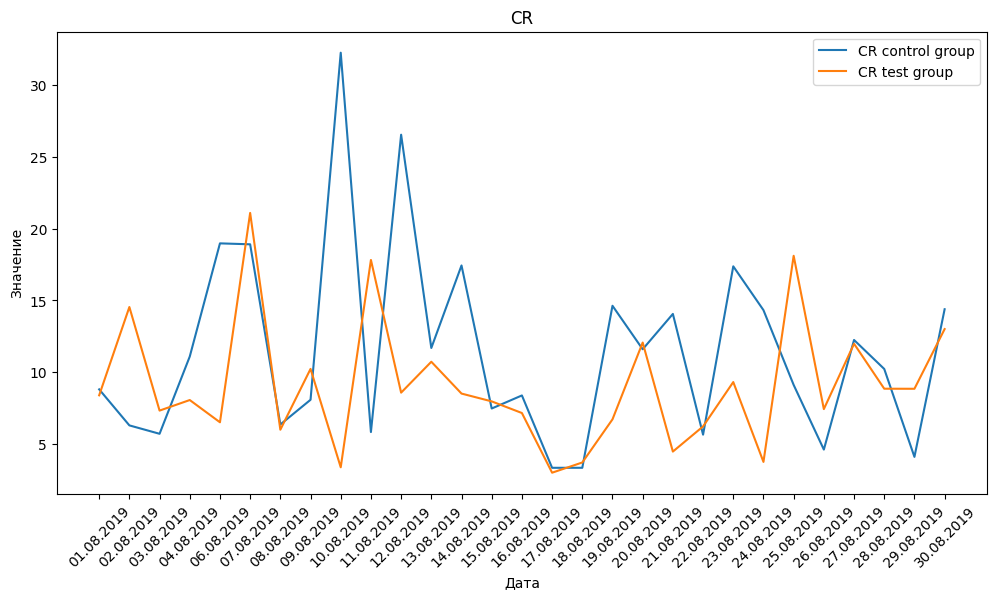

In [280]:

x = data_control_group['Date']
y1 = data_control_group['CTR']
y2 = data_test_group['CTR']

plt.figure(figsize=(12, 6)) 
plt.plot(x, y1, label='CTR control group')
plt.plot(x, y2, label='CTR test group')

plt.xlabel('Дата')
plt.ylabel('Значение')
plt.title('CTR')
plt.legend()
plt.xticks(rotation=45)
plt.show()

x = data_control_group['Date']
y1 = data_control_group['CPC']
y2 = data_test_group['CPC']

plt.figure(figsize=(12, 6)) 
plt.plot(x, y1, label='CPC control group')
plt.plot(x, y2, label='CPC test group')

plt.xlabel('Дата')
plt.ylabel('Значение')
plt.title('CPC')
plt.legend()
plt.xticks(rotation=45)
plt.show()

x = data_control_group['Date']
y1 = data_control_group['CPM']
y2 = data_test_group['CPM']

plt.figure(figsize=(12, 6)) 
plt.plot(x, y1, label='CPM control group')
plt.plot(x, y2, label='CPM test group')

plt.xlabel('Дата')
plt.ylabel('Значение')
plt.title('CPM')
plt.legend()
plt.xticks(rotation=45)
plt.show()

x = data_control_group['Date']
y1 = data_control_group['CPA']
y2 = data_test_group['CPA']

plt.figure(figsize=(12, 6)) 
plt.plot(x, y1, label='CPA control group')
plt.plot(x, y2, label='CPA test group')

plt.xlabel('Дата')
plt.ylabel('Значение')
plt.title('CPA')
plt.legend()
plt.xticks(rotation=45)
plt.show()

x = data_control_group['Date']
y1 = data_control_group['CR']
y2 = data_test_group['CR']

plt.figure(figsize=(12, 6)) 
plt.plot(x, y1, label='CR control group')
plt.plot(x, y2, label='CR test group')

plt.xlabel('Дата')
plt.ylabel('Значение')
plt.title('CR')
plt.legend()
plt.xticks(rotation=45)
plt.show()

## Виведемо дані по витратам та кількостям покупок (цільовим діям)

In [281]:
print(f"Сума грошей, витрачених на рекламні компанії тест групи {sum(data_test_group['Spend [USD]'])}")
print(f"Кількість покупок тест групи {sum(data_test_group['# of Purchase'])}")

Сума грошей, витрачених на рекламні компанії тест групи 66823
Кількість покупок тест групи 14869


In [282]:
print(f"Сума грошей, витрачених на рекламні компанії контрольної групи {sum(data_control_group['Spend [USD]'])}")
print(f"Кількість покупок контрольної групи {sum(data_control_group['# of Purchase'])}")

Сума грошей, витрачених на рекламні компанії контрольної групи 66818
Кількість покупок контрольної групи 15161


##### Виведемо графіки

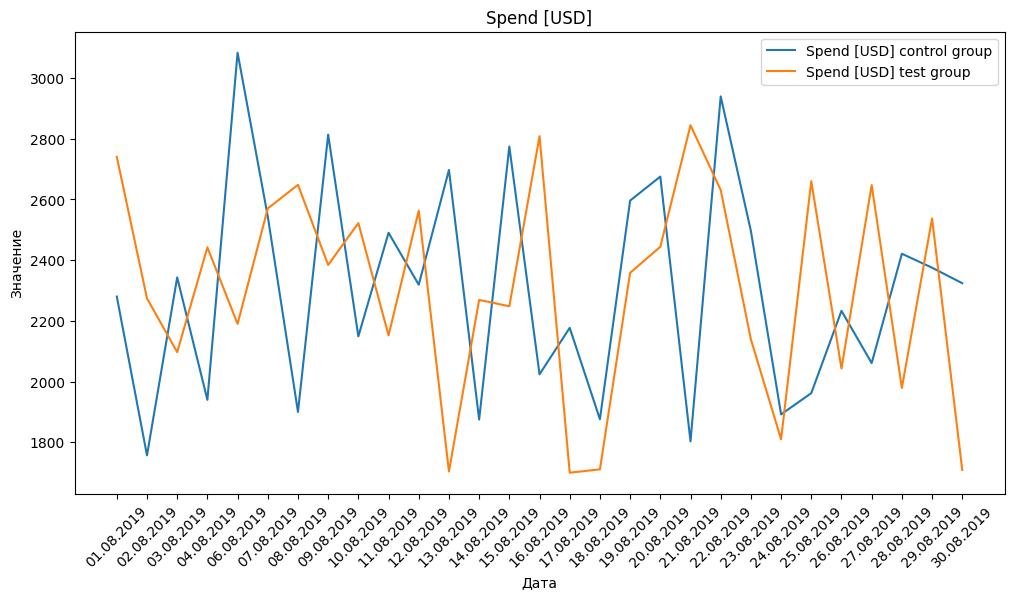

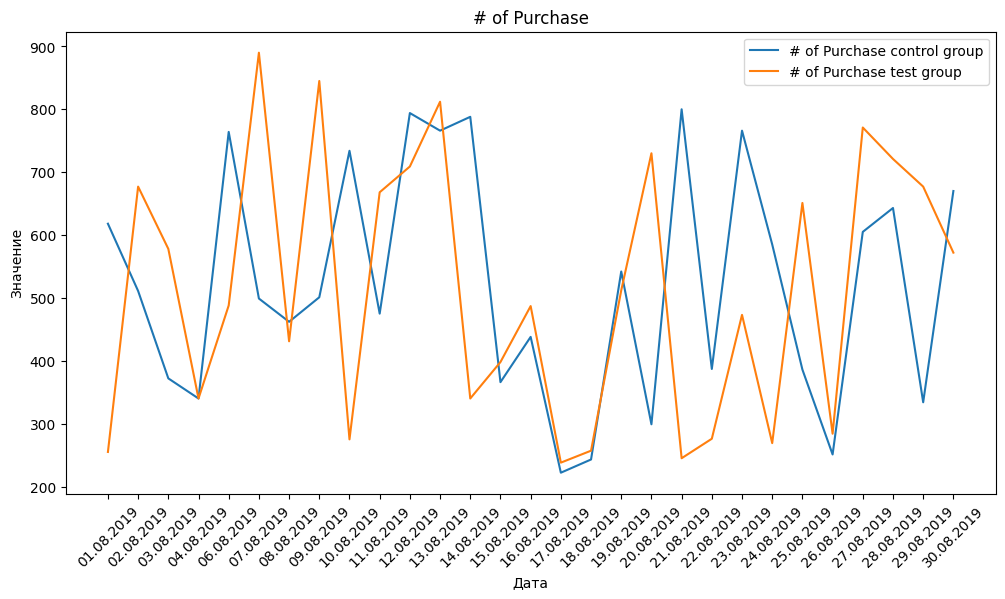

In [283]:
x = data_control_group['Date']
y1 = data_control_group['Spend [USD]']
y2 = data_test_group['Spend [USD]']

plt.figure(figsize=(12, 6)) 
plt.plot(x, y1, label='Spend [USD] control group')
plt.plot(x, y2, label='Spend [USD] test group')

plt.xlabel('Дата')
plt.ylabel('Значение')
plt.title('Spend [USD]')
plt.legend()
plt.xticks(rotation=45)
plt.show()

x = data_control_group['Date']
y1 = data_control_group['# of Purchase']
y2 = data_test_group['# of Purchase']

plt.figure(figsize=(12, 6)) 
plt.plot(x, y1, label='# of Purchase control group')
plt.plot(x, y2, label='# of Purchase test group')

plt.xlabel('Дата')
plt.ylabel('Значение')
plt.title('# of Purchase')
plt.legend()
plt.xticks(rotation=45)
plt.show()


## Проведемо безпосередньо A/B тестування ти взначення результатів значущості

In [284]:
indicators=data_test_group.columns[2:]
for indicator in indicators:
    if shapiro(data_test_group[indicator]).pvalue < 0.05:
        print(f'Ряд {indicator} не є нормально розподіленим. Середнє значення {data_test_group[indicator].mean()}')
    else:
        print(f'Ряд {indicator} є нормально розподіленим. Середнє значення {data_test_group[indicator].mean()}')
    if shapiro(data_control_group[indicator]).pvalue < 0.05:
        print(f'Ряд {indicator} не є нормально розподіленим. Середнє значення {data_control_group[indicator].mean()}')
    else:
        print(f'Ряд {indicator} є нормально розподіленим. Середнє значення {data_control_group[indicator].mean()}')
    print('')
    if (shapiro(data_test_group[indicator]).pvalue < 0.05) | (shapiro(data_control_group[indicator]).pvalue < 0.05):
        stat, p_value = mannwhitneyu(data_test_group[indicator], data_control_group[indicator])
        print(f'U-статистика: {stat}')
        print(f'P-значення: {p_value}')
        alpha = 0.05
        if p_value < alpha:
            print(f"Відхиляємо нульову гіпотезу:  розподіли по полю {indicator} значущо різні")
            if data_test_group[indicator].mean() > data_control_group[indicator].mean():
                print('Тестова група показала вищі результати')
            else:
                print('Контрольна група показала вищі результати')
        else:
            print(f"Не відхиляємо нульову гіпотезу: розподіли по полю {indicator} не значущо різні")
    else:
        stat, p_value = ttest_ind(data_test_group[indicator], data_control_group[indicator])
        print(f'T-статистика: {stat}')
        print(f'P-значення: {p_value}')
        alpha = 0.05
        if p_value < alpha:
            print(f"Відхиляємо нульову гіпотезу: розподіли по полю {indicator} значущо різні")
            if data_test_group[indicator].mean() > data_control_group[indicator].mean():
                print('Тестова група показала вищі результати')
            else:
                print('Контрольна група показала вищі результати')
        else:
            print(f"Не відхиляємо нульову гіпотезу: розподіли по полю {indicator} не значущо різні")
    print('--------------------------------------------------------------------------')
    print('')

Ряд Spend [USD] є нормально розподіленим. Середнє значення 2304.2413793103447
Ряд Spend [USD] є нормально розподіленим. Середнє значення 2304.0689655172414

T-статистика: 0.0018369748122432892
P-значення: 0.9985408353402256
Не відхиляємо нульову гіпотезу: розподіли по полю Spend [USD] не значущо різні
--------------------------------------------------------------------------

Ряд # of Impressions є нормально розподіленим. Середнє значення 73215.4827586207
Ряд # of Impressions є нормально розподіленим. Середнє значення 109559.75862068965

T-статистика: -5.086153756808527
P-значення: 4.395853596246194e-06
Відхиляємо нульову гіпотезу: розподіли по полю # of Impressions значущо різні
Контрольна група показала вищі результати
--------------------------------------------------------------------------

Ряд Reach є нормально розподіленим. Середнє значення 52055.48275862069
Ряд Reach є нормально розподіленим. Середнє значення 88844.93103448275

T-статистика: -5.556280238502353
P-значення: 7.915

In [260]:
data = {
    'A': data_test_group['CTR'].to_numpy(),
    'B': data_control_group['CTR'].to_numpy(),
}
df = pd.DataFrame(data)

df['Difference'] = df['A'] - df['B']

# Виведення таблиці
print("Таблиця:")
print(df)

# Обчислення підсумків
summary = pd.DataFrame(df[['Difference']].sum()).T
summary.index = ['Total']  # Задаємо індекс для рядка підсумків

# Створення рядка з рискою для відділення
separator = pd.DataFrame([['---', '---', '---']], columns=df.columns)
separator.index = ['-----']  # Задаємо індекс для розділювальної лінії

# Додавання рядка підсумків і розділювальної лінії до датафрейму
df_with_summary = pd.concat([df, separator, summary], ignore_index=False)

# Виведення таблиці з підсумками та розділювальною лінією
print("Таблиця з підсумками та розділювальною лінією:")
print(df_with_summary)

Таблиця:
            A         B  Difference
0    7.681416  8.483471   -0.802055
1    4.623755  6.700264   -2.076509
2   11.222123  4.941121    6.281002
3    5.374055  4.205659    1.168396
4    5.129708       NaN         NaN
5   17.542873  3.692838   13.850035
6    7.818694  1.857546    5.961148
7   21.337135  7.983373   13.353762
8   18.147261  5.108298   13.038963
9    8.547773  1.935829    6.611943
10   4.483876  7.060487   -2.576611
11   6.632903  2.566037    4.066866
12  11.496802  7.910968    3.585834
13   7.091858  3.112607    3.979251
14   5.292671  3.685498    1.607173
15   6.379944  7.329461   -0.949516
16   8.253081  5.541250    2.711831
17  12.882234  6.687751    6.194483
18  33.821766  3.434980   30.386786
19  15.328097  2.272767   13.055330
20   4.089825  7.623168   -3.533343
21  12.750345  6.473677    6.276669
22   8.421524  3.395442    5.026082
23  19.525239  5.633317   13.891922
24   2.982351  3.618618   -0.636266
25   4.725325  4.351586    0.373739
26   5.772905  4.72